In [1]:
#import modules
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### Part 1 - Exploratory data analysis

In [2]:
#load logins.json to df
logins_df = pd.read_json("Data/logins.json")

In [3]:
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
#check for missing values
logins_df.isnull().sum()

login_time    0
dtype: int64

In [5]:
#check dtype(s)
logins_df.dtypes

login_time    datetime64[ns]
dtype: object

In [6]:
#set login_time as index
logins_df.set_index('login_time', inplace=True)

In [7]:
#aggregate based on 15min intervals
login_counts_15min = logins_df.resample('15T').size()

C:\Users\aless\AppData\Local\Temp\ipykernel_25148\1254923089.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  login_counts_15min = logins_df.resample('15T').size()


In [8]:
login_counts_15min.head()

login_time
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
Freq: 15min, dtype: int64

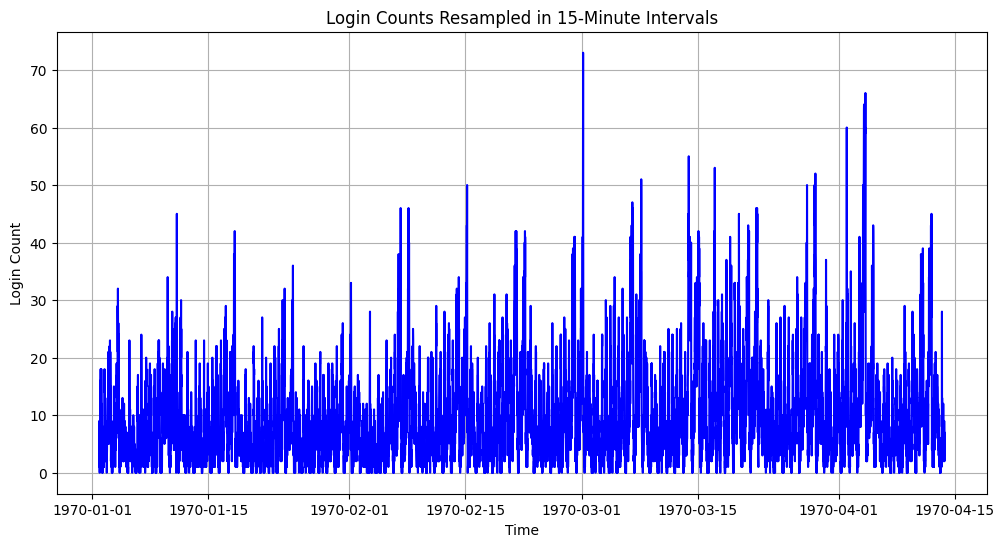

In [9]:
#visualize login counts
plt.figure(figsize=(12, 6))
plt.plot(login_counts_15min, color='blue')
plt.title('Login Counts Resampled in 15-Minute Intervals')
plt.xlabel('Time')
plt.ylabel('Login Count')
plt.grid(True)
plt.show()

C:\Users\aless\AppData\Local\Temp\ipykernel_25148\1700450690.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  login_counts_hourly = logins_df.resample('H').size()


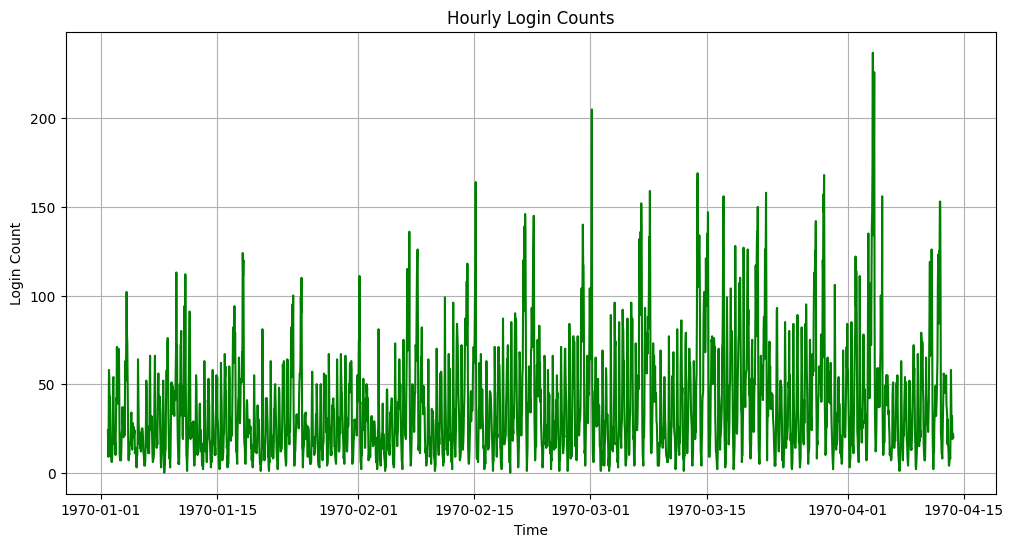

In [10]:
#resample by hour
login_counts_hourly = logins_df.resample('H').size()

#plot the hourly login counts
plt.figure(figsize=(12, 6))
plt.plot(login_counts_hourly, color='green')
plt.title('Hourly Login Counts')
plt.xlabel('Time')
plt.ylabel('Login Count')
plt.grid(True)
plt.show()

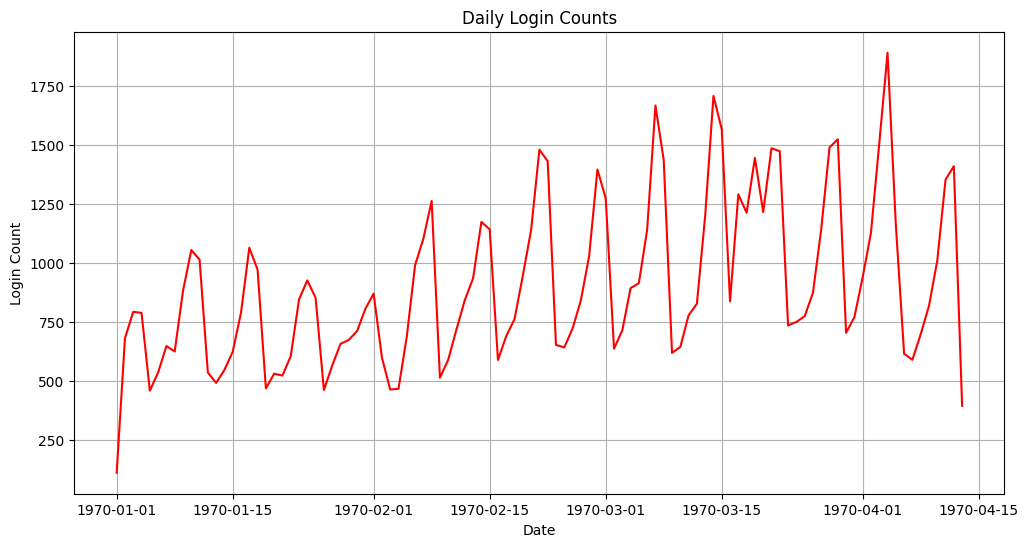

In [11]:
#resample by day
login_counts_daily = logins_df.resample('D').size()

#plot the daily login counts
plt.figure(figsize=(12, 6))
plt.plot(login_counts_daily, color='red')
plt.title('Daily Login Counts')
plt.xlabel('Date')
plt.ylabel('Login Count')
plt.grid(True)
plt.show()

### Part 2 - Experiment and metrics design

1) The key metric for success would be the number of cross-city trips made by driver partners. Specifically, this metric tracks how many drivers start their shift in one city and complete trips in the other city during their shift. The goal is to increase cross-city driving. The number of cross-city trips is a direct indicator of whether drivers are serving both cities after the toll reimbursement. This is also an easily measurable metric.

2) Experiment Design

a) Implementation of the Experiment
To implement the experiment, drivers will be randomly assigned to one of two groups: a control group that does not receive toll reimbursement, and a test group that receives toll reimbursement for cross-city trips between Gotham and Metropolis. Random assignment ensures that any observed changes in driver behavior can be attributed to the toll reimbursement rather than other external factors. Key data points, such as the number of trips within each city, cross-city trips, driver hours, and total distance traveled, will be tracked over the duration of the experiment. The experiment should run for several weeks or months to capture both weekday and weekend patterns, allowing for comprehensive insights into driver behavior.

b) Statistical Tests
To verify the significance of the results, a two-sample t-test (or Welch’s t-test if variances differ) will be used to compare the average number of cross-city trips between the test and control groups. The null hypothesis assumes that there is no difference in the number of cross-city trips between the groups, while the alternative hypothesis posits that the toll reimbursement increases the number of cross-city trips. Additionally, a chi-square test can be employed to analyze the association between toll reimbursement and whether a driver completes cross-city trips. Effect sizes, such as Cohen’s d, will also be calculated to determine the practical impact of toll reimbursement beyond statistical significance.

c) Interpretation of Results and Recommendations
If the results indicate statistical significance, showing that the test group took more cross-city trips than the control group, it would suggest that toll reimbursement is an effective strategy to encourage drivers to serve both cities. In this case, city operations should consider expanding the reimbursement policy to all drivers. However, if the results are not statistically significant, it may be necessary to explore alternative incentives, such as bonuses for cross-city trips. Care should be taken when interpreting the results, as external factors like city events or traffic conditions may influence outcomes, and the behavior change observed during the experiment could diminish over time. The experiment should also run long enough to account for seasonal or weekly traffic variations.

### Part 3 - Predictive modeling

#### 1. Data Cleaning and Exploratory Data Analysis

In [12]:
#load data
data = pd.read_json('Data/ultimate_data_challenge.json')
data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [13]:
data.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [14]:
#convert dates to datetime
data['signup_date'] = pd.to_datetime(data['signup_date'])
data['last_trip_date'] = pd.to_datetime(data['last_trip_date'])

In [15]:
#define cutoff date as 30 days before last  trip
cutoff_date = data['last_trip_date'].max() - pd.DateOffset(days=30)

In [16]:
#create retention target variable: True if user was active in last 30 days
data['retained'] = data['last_trip_date'] >= cutoff_date

In [17]:
#calculate fraction of retained users
retention_rate = data['retained'].mean()
print(f"Retention Rate: {retention_rate:.2%}")

Retention Rate: 37.61%


#### 2. Predictive Model

In [18]:
#select relevant features and target
features = ['city', 'phone', 'avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 
            'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct']
X = data[features]
y = data['retained']

In [19]:
#one-hot encode categorical variables
X = pd.get_dummies(X, columns=['city', 'phone'], drop_first=True)

In [20]:
#split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
#train RF classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [22]:
#make predictions
y_pred = model.predict(X_test)

In [23]:
#evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2%}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 77.32%
Confusion Matrix:
 [[8158 1221]
 [2181 3440]]
Classification Report:
               precision    recall  f1-score   support

       False       0.79      0.87      0.83      9379
        True       0.74      0.61      0.67      5621

    accuracy                           0.77     15000
   macro avg       0.76      0.74      0.75     15000
weighted avg       0.77      0.77      0.77     15000



I chose the Random Forest classifier because it is robust, handles non-linear relationships, and can manage missing values and feature interactions without much preprocessing. It's well-suited for classification tasks like rider retention, offering a good balance between performance and interpretability. While logistic regression offers simplicity, it may not capture complex patterns, and although XGBoost could improve accuracy, it requires more tuning and computational resources.

One concern is the class imbalance, with a 37.61% retention rate, which could lead to overprediction of non-retained users. Adjusting for class weights or using resampling techniques could improve performance. The model's accuracy of 77.32% shows reasonable performance, but with a precision of 0.74 and recall of 0.61 for retained users, the model may miss some retained users. Further optimization, such as threshold tuning, could help improve this balance.

#### 3. Model Insights

Ultimate can use the model’s insights to focus on users less likely to be retained, such as those with fewer trips in the first 30 days. Offering targeted incentives like discounts or personalized outreach could encourage continued usage. Additionally, improving driver ratings and service quality for users with lower ratings might increase retention, enhancing long-term rider engagement.